*It's a method used to determine customer value by looking at three dimensions:*

- **Recency**: When is the last time the user takes an action? 
- **Frequency**: How many times does the user take this action?
- **Monetary**: What is the sum of monetary value from this user throughout his/her lifetime?

- *Recency : the interval between the **last action** and **today***
- *Frequency : the number of action between the user's **signup date** and **today***
- *Monetary : the sum of revenue within the user's lifetime*

### Library

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


In [2]:
df = pd.read_csv("C:/Users/emirh/OneDrive/Belgeler/GitHub/CRM/RFM_analysis/online_retail_listing.csv",delimiter=";",encoding="unicode_escape")

In [3]:
def check_df(df):
    print("---------------- Shape ----------------")
    print(df.shape)
    print("---------------- Columns ----------------")
    print(df.columns)
    print("---------------- Types ----------------")
    print(df.dtypes)
    print("---------------- Head ----------------")
    print(df.head())
    print("---------------- Tail ----------------")
    print(df.tail())
    print("---------------- Describe ----------------")
    print(df.describe().T)

check_df(df)    

---------------- Shape ----------------
(1048575, 8)
---------------- Columns ----------------
Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')
---------------- Types ----------------
Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price           object
Customer ID    float64
Country         object
dtype: object
---------------- Head ----------------
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

       InvoiceDate Price  Customer ID         Country  
0  1.12.2009 

In [4]:
df["Price"] = df["Price"].str.replace(",",".").astype("float64")

In [5]:
df.Price.dtype

dtype('float64')

In [6]:
df["Total_Price"] = df["Quantity"] * df["Price"]
df["Total_Price"].head()

0     83.4
1     81.0
2     81.0
3    100.8
4     30.0
Name: Total_Price, dtype: float64

### Top 5 Most Ordered Product

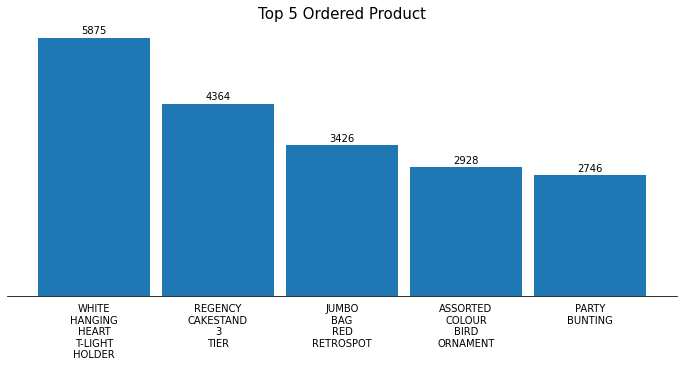

In [7]:
fig, ax = plt.subplots(figsize=(12,5))

counts = (df
          .Description
          .value_counts()
          .head()
          )


(counts
.plot.bar(width=.9, rot=0, ax=ax)
)

ax.set_xticklabels(["\n".join(label.split()) for label in counts.index])
ax.spines[["top","right","left"]].set_visible(False)
ax.set_title("Top 5 Ordered Product",fontsize=15)

ax.get_yaxis().set_visible(False)
ax.tick_params(bottom=False)
for pos, value in enumerate(counts):
    ax.text(pos, value+100, f"{value}",ha="center")

### Top 5 Expensive Product

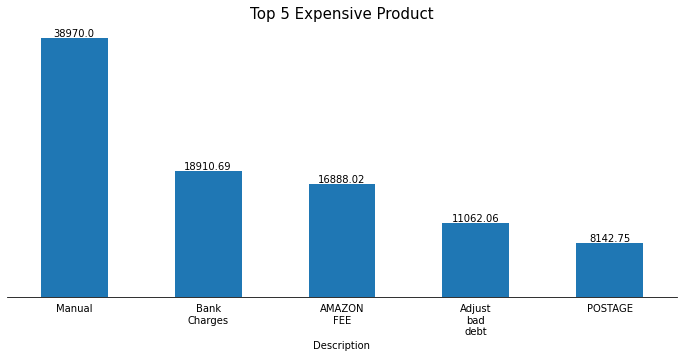

In [8]:
fig, ax = plt.subplots(figsize=(12,5))
max_desc =(df
.groupby("Description")
.Price
.max()
.sort_values(ascending=False)
.head()
)
(
max_desc
.plot(kind="bar",rot=0, ax=ax)
)
ax.set_xticklabels(["\n".join(label.split()) for label in max_desc.index])
ax.spines[["top","right","left"]].set_visible(False)
ax.set_title("Top 5 Expensive Product",fontsize=15)

ax.get_yaxis().set_visible(False)
ax.tick_params(bottom=False)
for pos, value in enumerate(max_desc):
    ax.text(pos, value+200, f"{value}",ha="center")

### How many orders came from which country?

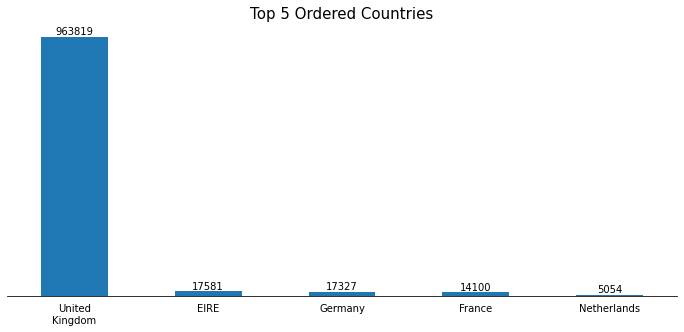

In [9]:
fig ,ax = plt.subplots(figsize=(12,5))
c_counts=(df
.Country
.value_counts()
.head()
)
(
c_counts
.plot(kind="bar",rot=0,ax=ax)
)
ax.set_xticklabels(["\n".join(label.split()) for label in c_counts.index])
ax.spines[["top","left","right"]].set_visible(False)
ax.set_title("Top 5 Ordered Countries",fontsize=15)
ax.get_yaxis().set_visible(False)
ax.tick_params(bottom=False)
for pos, value in enumerate(c_counts):
    ax.text(pos, value+10000, f"{value}",ha="center")

### The invoice with the most expensive purchase

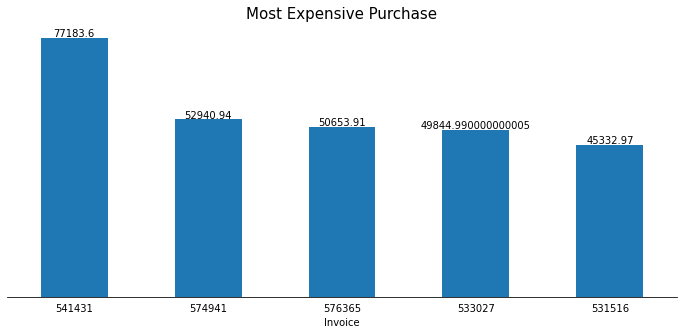

In [10]:
fig, ax = plt.subplots(figsize=(12,5))

i_counts=(df
.groupby("Invoice")
.Total_Price
.sum()
.sort_values(ascending=False)
.head()
)
(
i_counts
.plot(kind="bar",rot=0,ax=ax)
)
ax.spines[["top","left","right"]].set_visible(False)
ax.set_title("Most Expensive Purchase",fontsize=15)
ax.get_yaxis().set_visible(False)
ax.tick_params(bottom=False)
for pos, value in enumerate(i_counts):
    ax.text(pos, value+200, f"{value}",ha="center")



## Missing data analysis

In [11]:
(df
.isna()
.mean()
.mul(100))

Invoice         0.000000
StockCode       0.000000
Description     0.416947
Quantity        0.000000
InvoiceDate     0.000000
Price           0.000000
Customer ID    22.571776
Country         0.000000
Total_Price     0.000000
dtype: float64

In [12]:
df.dropna(inplace=True)

In [13]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
Total_Price    0
dtype: int64

## Outlier Engineering

<AxesSubplot:>

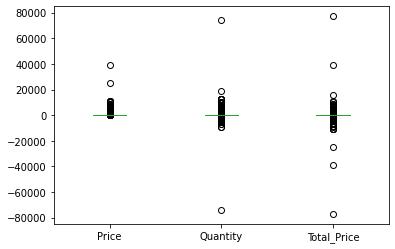

In [14]:
df[["Price","Quantity","Total_Price"]].plot(kind="box")


In [15]:
def outlier(data,col):
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    lower = data[col].quantile(0.25) - (IQR * 1.5)
    upper  = data[col].quantile(0.75) + (IQR * 1.5)
    b_total = df[(df[col] > upper) | (df[col] < lower)].shape[0]
    print(f"Total Outliers of the {col} : {b_total}")
    df[col] = np.where(df[col]<lower,lower,np.where(df[col]>upper,upper,data[col]))
    a_total = df[(df[col] > upper) | (df[col] < lower)].shape[0]
    print(f"(After Replacement) Total Outliers of the {col} : {a_total}")

In [16]:
for col in ["Quantity","Price","Total_Price"]:
    outlier(df,col)

Total Outliers of the Quantity : 53226
(After Replacement) Total Outliers of the Quantity : 0
Total Outliers of the Price : 70281
(After Replacement) Total Outliers of the Price : 0
Total Outliers of the Total_Price : 68158
(After Replacement) Total Outliers of the Total_Price : 0


### How many unique items in the dataset?

In [17]:
df["Description"].nunique()

5297

### Remove the canceled transactions from the dataset


In [18]:
df = df[~df["Invoice"].str.contains("C", na=False)]

### Drop duplicate

In [19]:
df.drop_duplicates(subset=["Invoice", "Customer ID"], keep="first", inplace=True)


## Calculating of RFM metrics

In [20]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["InvoiceDate"].max() # last purchase '9.12.2010 20:01'
today_date = dt.datetime(2012,1,1)


In [21]:
rfm = df.groupby("Customer ID").agg(
    {"InvoiceDate" : lambda date: (today_date - date.max()).days,
    "Invoice" : lambda num: len(num),
    "Total_Price": lambda  TotalPrice: TotalPrice.sum()}
)
rfm.columns=["Recency","Frequency","Monetary"]

In [22]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,5863.0,233.085622,213.814489,21.0,51.0,142.000,401.0000,1083.00
Frequency,5863.0,6.219171,12.860518,1.0,1.0,3.000,7.0000,391.00
Monetary,5863.0,132.694303,337.015846,0.0,20.4,52.575,127.1875,9562.18


In [23]:
rfm["R_Score"] = pd.qcut(rfm["Recency"],5,labels=[5,4,3,2,1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"),5, labels=[1,2,3,4,5])
rfm["M_Score"] = pd.qcut(rfm["Monetary"],5,labels=[1,2,3,4,5])
rfm["RFM_Score"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)
rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
Customer ID,,,,,,,
12346.0,347,12,253.990,2,5,5,255
12347.0,61,7,160.835,4,4,5,445
12348.0,97,5,179.310,3,4,5,345
12349.0,40,4,95.025,5,3,4,534
12350.0,332,1,25.200,2,1,2,212


In [24]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

rfm["Segment"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str)
rfm["Segment"] = rfm["Segment"].replace(seg_map, regex=True)
rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
Customer ID,,,,,,,,
12346.0,347,12,253.990,2,5,5,255,cant_loose
12347.0,61,7,160.835,4,4,5,445,loyal_customers
12348.0,97,5,179.310,3,4,5,345,loyal_customers
12349.0,40,4,95.025,5,3,4,534,potential_loyalists
12350.0,332,1,25.200,2,1,2,212,hibernating


### Who are the top 10 of our best customers?

In [25]:
rfm[rfm["RFM_Score"]=='555'].sort_values("Monetary", ascending=False).head(10)

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
Customer ID,,,,,,,,
14911.0,21,391,9562.180,5,5,5,555,champions
13089.0,27,201,5941.140,5,5,5,555,champions
18102.0,33,142,5854.860,5,5,5,555,champions
14646.0,23,149,5521.655,5,5,5,555,champions
15311.0,21,206,5045.825,5,5,5,555,champions
15061.0,26,126,4863.370,5,5,5,555,champions
17949.0,24,116,4830.495,5,5,5,555,champions
14156.0,21,156,4682.865,5,5,5,555,champions
13798.0,22,108,4386.210,5,5,5,555,champions


### Summary Statistics for RFM

In [26]:
(rfm[["Segment","Recency","Frequency", "Monetary"]]
.groupby("Segment")
.agg(["mean","median","count","std","min","max","skew"])
)


Recency                                                \
                           mean median count         std  min   max      skew   
Segment                                                                         
about_to_sleep       151.775561  150.0   401   40.896815   94   225  0.127685   
at_Risk              397.976127  400.0   754  110.892046  226   932  0.553084   
cant_loose           343.959459  347.5    74   89.036615  226   566  0.351590   
champions             32.470106   33.0   853    7.242163   21    44 -0.056338   
hibernating          497.285714  471.5  1512  163.474956  226  1083  0.671043   
loyal_customers       99.590510   86.0  1138   47.810046   45   225  0.897529   
need_attention       152.029740  148.0   269   40.836485   94   225  0.162667   
new_customers         35.321429   36.0    56    6.472620   21    44 -0.679879   
potential_loyalists   52.601164   47.0   687   18.942475   21    93  0.405589   
promising             69.361345   71.0   119   14.925085   45    93 -0.069281   

                     Frequency               ...                     \
                          mean median count  ... min  max      skew   
Segment                                      ...                      
about_to_sleep        1.411471    1.0   401  ...   1    2  0.361152   
at_Risk               3.812997    3.0   754  ...   2    8  0.861935   
cant_loose           14.756757   11.0    74  ...   8  155  6.946262   
champions            18.361079   11.0   853  ...   4  391  7.080884   
hibernating           1.236111    1.0  1512  ...   1    2  1.243967   
loyal_customers      10.202988    8.0  1138  ...   4  140  6.149720   
need_attention        3.085502    3.0   269  ...   2    4 -0.084569   
new_customers         1.000000    1.0    56  ...   1    1  0.000000   
potential_loyalists   2.595342    3.0   687  ...   1    4 -0.033359   
promising             1.000000    1.0   119  ...   1    1  0.000000   

                       Monetary                                              \
                           mean   median count         std    min       max   
Segment                                                                       
about_to_sleep        28.713853   25.200   401   19.017671   0.72    84.750   
at_Risk               74.582115   64.400   754   51.241060   2.40   296.625   
cant_loose           303.018176  215.305    74  405.511911  30.87  3223.855   
champions            411.406542  204.190   853  716.768867  13.55  9562.180   
hibernating           23.781532   17.700  1512   17.834603   0.00    84.750   
loyal_customers      218.111450  149.715  1138  299.975115   5.53  5826.720   
need_attention        61.901245   60.450   269   33.165342   4.15   169.500   
new_customers         19.541071   16.100    56   12.796658   0.00    42.375   
potential_loyalists   47.794811   42.380   687   32.569028   0.75   169.500   
promising             17.942269   15.000   119   12.775668   0.85    42.375   

                               
                         skew  
Segment                        
about_to_sleep       0.922116  
at_Risk              1.357973  
cant_loose           5.575701  
champions            6.069905  
hibernating          1.158219  
loyal_customers      9.933558  
need_attention       0.570079  
new_customers        0.565933  
potential_loyalists  0.856106  
promising            0.772701  

[10 rows x 21 columns]

### Recency by Segment Plot

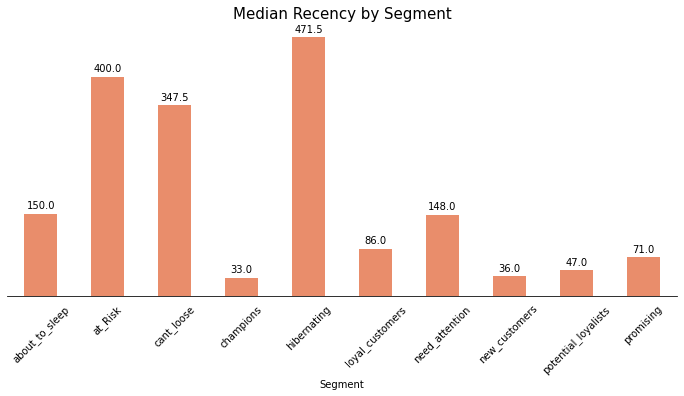

In [90]:
fig,ax = plt.subplots(figsize=(12,5))
rec_data = (rfm
            .groupby("Segment")
            .Recency
            .median()
            .head(10)
            )
(rec_data.plot.bar(ax=ax,rot=45))

ax.spines[["top","left","right"]].set_visible(False)
ax.set_title("Median Recency by Segment",fontsize=15)
ax.get_yaxis().set_visible(False)
ax.tick_params(bottom=False)
for pos, value in enumerate(rec_data):
    ax.text(pos, value+10, f"{value}",ha="center")



### Frequency by Segment Plot

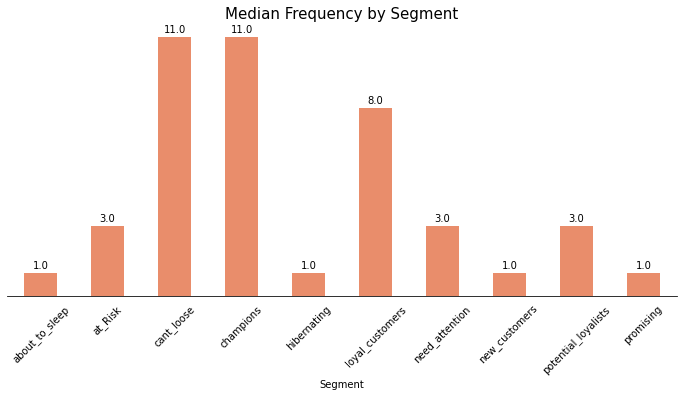

In [96]:
fig,ax = plt.subplots(figsize=(12,5))
freq_data = (rfm
            .groupby("Segment")
            .Frequency
            .median()
            .head(10)
            )
(freq_data.plot.bar(ax=ax,rot=45))

ax.spines[["top","left","right"]].set_visible(False)
ax.set_title("Median Frequency by Segment",fontsize=15)
ax.get_yaxis().set_visible(False)
ax.tick_params(bottom=False)
for pos, value in enumerate(freq_data):
    ax.text(pos, value+0.2, f"{value}",ha="center")



### Monetary by Segment Plot

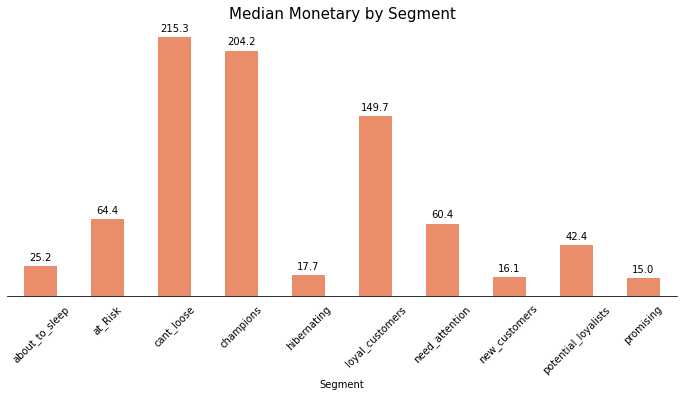

In [100]:
fig,ax = plt.subplots(figsize=(12,5))
mon_data = (rfm
            .groupby("Segment")
            .Monetary
            .median()
            .head(10)
            )
(mon_data.plot.bar(ax=ax,rot=45))

ax.spines[["top","left","right"]].set_visible(False)
ax.set_title("Median Monetary by Segment",fontsize=15)
ax.get_yaxis().set_visible(False)
ax.tick_params(bottom=False)
for pos, value in enumerate(round(mon_data,1)):
    ax.text(pos, value+5, f"{value}",ha="center")



## Clustring With The K-MEANS 

In [30]:
rfm_kmeans = rfm.loc[:,"Recency":"Monetary"]
rfm_kmeans.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,347,12,253.990
12347.0,61,7,160.835
12348.0,97,5,179.310
12349.0,40,4,95.025
12350.0,332,1,25.200


In [31]:
scaler = MinMaxScaler()
ndf = scaler.fit_transform(rfm_kmeans)

### Determining the K-Means Cluster Number - Inertia

In [32]:
max_cluster = 10

all_experiments = []

for n_cluster in range(1,max_cluster,1):
    kmeans = KMeans(n_clusters=n_cluster + 1, random_state=42)
    kmeans.fit(ndf)
    all_experiments.append(kmeans)

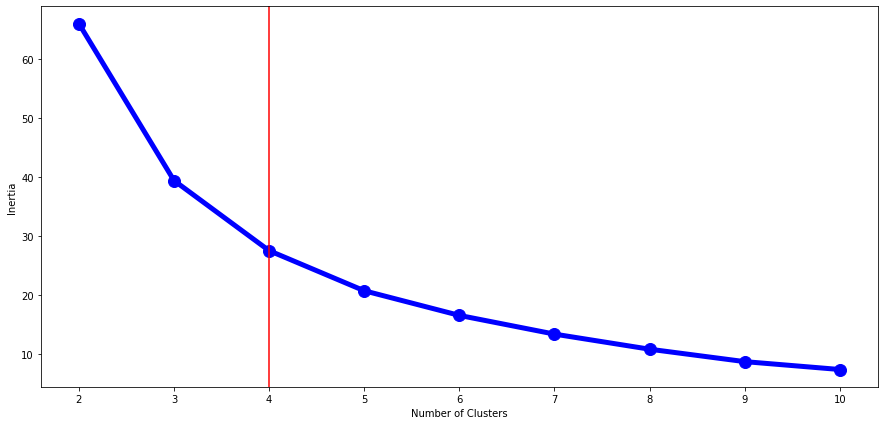

In [33]:
inertias = [experiment.inertia_ for experiment in all_experiments]
plt.figure(figsize=(15, 7))
plt.plot([2, 3, 4, 5, 6, 7, 8,9,10], inertias, 'bo-', linewidth=5, markersize=12)
plt.axvline(x=4,color="r")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

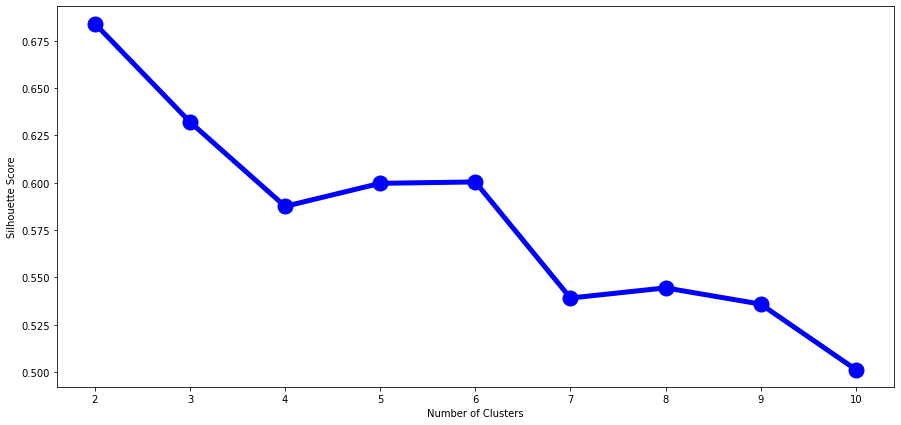

In [34]:
from sklearn.metrics import silhouette_score,silhouette_samples
silhouette_scores = [silhouette_score(ndf, experiment.labels_) for experiment in all_experiments]
plt.figure(figsize=(15, 7))
plt.plot([2, 3, 4, 5, 6, 7, 8,9,10], silhouette_scores, 'bo-', linewidth=5, markersize=15)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()
